In [1]:
#Helper Functions for Data processing:

import pandas as pd
import numpy as np
import geopandas as gpd
import dask 
import numba
import libpysal as lp
from rasterstats import zonal_stats
import os
import rasterio
from pathlib import Path
import json
from rasterio.mask import mask



/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def read_spatial(path, espg_code):
    '''
    Function to read spatial data and converts to ESPG 3435
    Input: path to the data file
            epgs_code (string): epsg code as a string
    Output: a gpd object 
    '''
    epsg = "EPSG:" + espg_code
    file=gpd.read_file(path)
    file=file.to_crs(epsg)
    print(path, file.crs)
    return file

data/com_areas_chi EPSG:32616


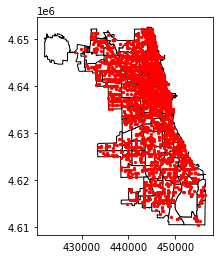

In [75]:
#GET TOY TEST DATA:
com_areas = read_spatial("data/com_areas_chi", "32616")
bike_rack_points = pd.read_csv('data/Bike_Racks.csv')
bike_rack_points = bike_rack_points.rename(columns = {"LOCATION":"geometry"})
bike_racks = gpd.GeoDataFrame(
    bike_rack_points, geometry=gpd.points_from_xy(bike_rack_points.Longitude,
                                                  bike_rack_points.Latitude), 
    crs="EPSG:4326")
bike_racks = bike_racks.to_crs("EPSG:32616")
bike_racks = bike_racks[["RackID", "Address", "F12", "F13", "geometry"]]
bike_racks["F12"] = bike_racks["F12"].round(1)
bike_racks["F13"] = bike_racks["F13"].round(1)
base = com_areas.plot(color='white', edgecolor='black')
bike_racks.plot(ax=base, marker='o', color='red', markersize=5);

In [5]:
def conduct_point_to_polygon(polygon_data, poly_unique_id, other_file):
    '''
    A function that creates a new dataset with spatial join of pyolgon data to points
    Inputs:
        polygon_data (gpd): polygon data (i.e. Community Areas)
        poly_unique_id (list of strings): the unique identifiers of the polygon spatial data
        other_file (gpd): another point-based gpd. Data from this will be aggregated 
                          to the polygon scale
        agg_dict (dict keys: strings - col names in point data
                       values: strings or list of strings - how to aggregate)
                       
    Output:
        the polygon_data dataframe updated with the new column
    Note: .size suggestion from here: https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
    '''
    spatial_join = gpd.sjoin(other_file, 
                             polygon_data[poly_unique_id + ["geometry"]], 
                             how="inner", 
                             op='intersects')
    
    return spatial_join
#USE CASE: 
#INPUT com areas and point data with all of the ND.. features
#We get the com area the point data is in


In [8]:
#Toy Test:
bike_ag_dict = {'RackID': ['min', 'max'], 'Address': 'size'}

com_area_w_bike = conduct_point_to_polygon(com_areas, 
                                           ["community", "area_numbe"], 
                                           bike_racks)
com_area_w_bike

,RackID,Address,F12,F13,geometry,index_right,community,area_numbe
0,3492,1391 N Milwaukee Ave,41.9,-87.7,POINT (1164227.030 1909454.074),24,WEST TOWN,24
2,5945,1001 N Damen Ave,41.9,-87.7,POINT (1162920.382 1906709.783),24,WEST TOWN,24
9,483,1943 W North Ave,41.9,-87.7,POINT (1163003.301 1910601.713),24,WEST TOWN,24
15,4118,1147 N Western Ave,41.9,-87.7,POINT (1160251.418 1907653.047),24,WEST TOWN,24
29,6518,2222 W North Ave,41.9,-87.7,POINT (1161205.566 1910644.139),24,WEST TOWN,24
...,...,...,...,...,...,...,...,...
4856,5419,6566 N Avondale Ave,42.0,-87.8,POINT (1125123.306 1942869.087),76,EDISON PARK,9
4921,3616,6700 N Olmsted Ave,42.0,-87.8,POINT (1124580.663 1943783.780),76,EDISON PARK,9
5056,3589,6755 N Northwest Highway Hwy,42.0,-87.8,POINT (1124321.999 1944489.194),76,EDISON PARK,9
4422,4492,9130 S University Ave,41.7,-87.6,POINT (1185424.432 1844638.524),42,BURNSIDE,47


In [9]:
def agg_cell_data(df, cols_to_group_by, ag_dict):
    '''
    Function to aggregate point weather data the cols_to_group_by and perform aggregations
    as specificed in the aggregation_dictionary
    Inputs:
        df the dataframe
        cols_to_group_by (list of strings): columns in df
        ag_dict (dictionary of strings to list of strings): maps column names to 
                                    aggregation operations
    Outputs:
        aggregated df
    '''
    df_new = df.groupby(cols_to_group_by).agg(ag_dict)
    
    return df_new

#USE CASE: ONCE WE HAVE PREVIOUS DATA, WE GROUP BY COM AREA, PERIOD, YEAR
# THEN WE AGGREGATE: MEAN, MAX OF DIFFERENT ND.. COLS


In [10]:
cols = ["area_numbe", "F12"]
ag_dict1 = {"RackID":"mean", "F13": ["min", "max"]}
bike_rack_agg = agg_cell_data(com_area_w_bike, cols_to_group_by = cols, 
                             ag_dict = ag_dict1)
bike_rack_agg


RackID   F13      
                        mean   min   max
area_numbe F12                          
1          42.0  3457.823529 -87.7 -87.7
10         42.0  3865.415385 -87.8 -87.8
11         42.0  3822.250000 -87.8 -87.8
12         42.0  2975.440000 -87.8 -87.7
13         42.0  3948.485714 -87.7 -87.7
...                      ...   ...   ...
75         41.7  4107.976744 -87.7 -87.6
76         42.0  2381.750000 -87.8 -87.8
77         42.0  3398.801653 -87.7 -87.7
8          41.9  3801.804965 -87.7 -87.6
9          42.0  3667.050000 -87.8 -87.8

[92 rows x 3 columns]

In [18]:
com_areas

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((1181573.250 1886828.039, 1181571.200..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((1186289.356 1876750.733, 1186247.037..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((1176344.998 1871187.546, 1176346.500..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((1182322.043 1876674.730, 1182323.670..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((1186289.356 1876750.733, 1186290.775..."
...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((1158152.274 1836518.250, 1158160.983..."
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((1173045.882 1828593.191, 1172952.890..."
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((1119302.584 1938024.319, 11193..."
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((1168756.115 1942653.009, 1168756.116..."


In [42]:
#Get raster data:
SHARED_DATA_FOLDER = Path('tif_data_2021')
#construct SCENE NAME
# path_row = []  
# year = []
# month = []
# day = []
SCENE = 'LC08_L2SP_022031_20210514_20210525_02_T1'
#check if scene_path is a file
scene_path = SHARED_DATA_FOLDER/SCENE
b1_path =scene_path/"{}_SR_B2.TIF".format(SCENE)
b1 = rasterio.open(b1_path)
chi_b = gpd.read_file("chi_b")
chi_b = chi_b.to_crs("EPSG:32616")




In [82]:
b1 = rasterio.open(b1_path)

In [99]:
b1.crs

CRS.from_epsg(32616)

In [53]:
def clip_raster(raster, vector_poly):
    '''
    Clip raster polygon with the vecotr polygon boundary
    Input: 
        raster - rasterio object (i.e. read from rasterio.open)
        vector_poly - geopandas dataframe
    Output:
        raster object that is clipped
    '''
    vector_poly_good_crs = vector_poly.to_crs(raster.crs)
    vector_as_json = [json.loads(vector_poly.to_json())['features'][0]['geometry']]
    
    out_img, out_transform = mask(dataset=raster, 
                                  shapes=vector_as_json, 
                                  crop=True)
    return out_img, out_transform
    
    

In [199]:
new_raster, new_raster_transform = clip_raster(b1, chi_b)

In [161]:
import sys 
np.set_printoptions(threshold=1000)


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>, ...,
        <AxesSubplot:title={'center':'31'}>,
        <AxesSubplot:title={'center':'32'}>,
        <AxesSubplot:title={'center':'33'}>],
       [<AxesSubplot:title={'center':'34'}>,
        <AxesSubplot:title={'center':'35'}>,
        <AxesSubplot:title={'center':'36'}>, ...,
        <AxesSubplot:title={'center':'65'}>,
        <AxesSubplot:title={'center':'66'}>,
        <AxesSubplot:title={'center':'67'}>],
       [<AxesSubplot:title={'center':'68'}>,
        <AxesSubplot:title={'center':'69'}>,
        <AxesSubplot:title={'center':'70'}>, ...,
        <AxesSubplot:title={'center':'99'}>,
        <AxesSubplot:title={'center':'100'}>,
        <AxesSubplot:title={'center':'101'}>],
       ...,
       [<AxesSubplot:title={'center':'1088'}>,
        <AxesSubplot:title={'center':'1089'}>,
        <AxesSubplot:title={'center':'1090'}>, ...,
        <AxesSu

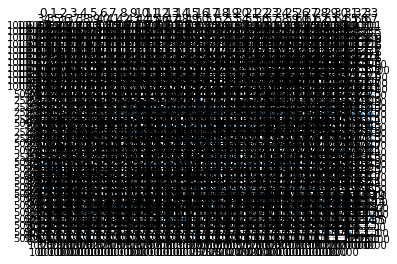

In [202]:
pd.DataFrame(new_raster[0]).hist()

In [163]:
new_raster

array([[[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ..., 10508, 10118, 10047],
        [    0,     0,     0, ..., 10394, 10340, 10008],
        [    0,     0,     0, ..., 10294, 10444, 10315]]], dtype=uint16)

In [73]:
com_areas

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,av_area_num
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((449429.813 4632712.182, 449429.135 4...",3.573557e+07
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((450818.899 4629619.879, 450806.010 4...",4.118962e+07
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((447763.097 4627972.082, 447763.324 4...",6.620223e+07
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((449609.917 4629615.480, 449610.009 4...",3.245036e+07
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((450818.899 4629619.879, 450819.110 4...",3.822143e+07
...,...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((442056.996 4617496.001, 442058.132 4...",9.032835e+07
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((446556.956 4615011.389, 446528.614 4...",9.553566e+07
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((430701.343 4648604.251, 430701...",1.127771e+08
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((445789.555 4649779.811, 445789.556 4...",7.153424e+07


In [33]:

def compute_spatial_lag(gpd, column, new_col_name, time_indentifier):
    '''
    Creates a new column in the dataframe that calculates the spatial lag
    Spatial lag defined as the average of the neighbors
    Neighbors are defined using first order queen contiguity
    
    Inputs:
        gpd - a geopandas dataframe
        column - the column on which to create the spatial lag
        new_col_name - the name of the spatial lag column
        time-identifier - a column that identifies the time periods
            in the data
    Ouput:
        gpd - the updated dataframe with the new columns
    
    '''        
    weights_matrix = lp.weights.Queen.from_dataframe(gpd)
    weights_matrix.transform = "r"
    data_series = gpd[column]
    gpd[new_col_name] = lp.weights.lag_spatial(weights_matrix, 
                                                          gpd[column])
    return gpd

In [88]:
com_w_weighted_area = compute_spatial_lag(com_areas, "shape_area", "lag_shape_len", "time")

In [130]:
com_w_weighted_area[com_w_weighted_area["area_numbe"] == "2"]

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,lag_shape_area,lag_shape_len
19,0.0,2,2,0.0,0.0,WEST RIDGE,0.0,9.842909e+07,43020.689458,"POLYGON ((443315.818 4652166.308, 443316.880 4...",6.033773e+07,6.033773e+07


In [193]:
def compute_max(list_of_arrays):
    '''
    Function that computes the elementwise max of the arrays in the list of arrays
    Inputs:
        list_of_arrays (list of 1D np arrays), note the arrays should be the same size
    Output:
        max_array (1D np array): the elementwise max from each array
    '''
    max_array = np.maximum(*list_of_arrays)
    return max_array
a = np.array([[1, 2], [4, -1]])    
b = np.array([[-1, 5], [0, 1]])
compute_max([a, b])

array([[1, 5],
       [4, 1]])

In [191]:
≈
l = [a, b]
c = np.maximum(*l)

In [192]:
c

array([[ 5,  2],
       [ 5, -1]])

In [186]:
m.shape

(2, 2, 2)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [169]:
c.shape

(2, 2, 2)

In [166]:
x for x in l

SyntaxError: invalid syntax (<ipython-input-166-263b443a7b9c>, line 1)

In [161]:
c

array([[ 5,  2],
       [ 5, -1]])

In [157]:
c

array([5, 2])

In [152]:
c

7

In [149]:
c

array([5, 2])

In [122]:
com_areas.dtypes

area               float64
area_num_1          object
area_numbe          object
comarea            float64
comarea_id         float64
community           object
perimeter          float64
shape_area         float64
shape_len          float64
geometry          geometry
lag_shape_area     float64
lag_shape_len      float64
dtype: object

In [133]:
#Create Weights Matrix:


#Get pysal weights matrix:
weights_matrix = lp.weights.Queen.from_dataframe(com_areas, idVariable='area_numbe')

#Access their dictionary
w_dict = weights_matrix.neighbors
W = np.zeros((77, 77))

for com_area, list_of_neighbors in w_dict.items():
    for neighbor in list_of_neighbors:
        W[int(com_area) -1, int(neighbor) -1] = 1
        
#Standardize:
sum_of_rows = W.sum(axis=1)
W = W / sum_of_rows[:, np.newaxis]


In [146]:
com_areas

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,lag_shape_area,lag_shape_len
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((449429.813 4632712.182, 449429.135 4...",3.573557e+07,3.573557e+07
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((450818.899 4629619.879, 450806.010 4...",4.118962e+07,4.118962e+07
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((447763.097 4627972.082, 447763.324 4...",6.620223e+07,6.620223e+07
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((449609.917 4629615.480, 449610.009 4...",3.245036e+07,3.245036e+07
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((450818.899 4629619.879, 450819.110 4...",3.822143e+07,3.822143e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.0,74,74,0.0,0.0,MOUNT GREENWOOD,0.0,7.558429e+07,48665.130539,"POLYGON ((442056.996 4617496.001, 442058.132 4...",9.032835e+07,9.032835e+07
73,0.0,75,75,0.0,0.0,MORGAN PARK,0.0,9.187734e+07,46396.419362,"POLYGON ((446556.956 4615011.389, 446528.614 4...",9.553566e+07,9.553566e+07
74,0.0,76,76,0.0,0.0,OHARE,0.0,3.718356e+08,173625.984660,"MULTIPOLYGON (((430701.343 4648604.251, 430701...",1.127771e+08,1.127771e+08
75,0.0,77,77,0.0,0.0,EDGEWATER,0.0,4.844999e+07,31004.830946,"POLYGON ((445789.555 4649779.811, 445789.556 4...",7.153424e+07,7.153424e+07


In [147]:
ca = np.array(com_areas[["area_numbe", "shape_len"]])
ca = ca[np.argsort(ca[:, 0])]
ca

array(['10', 80368.3743778], dtype=object)

In [68]:
w_dict

{0: [33, 34, 3, 1],
 1: [0, 3, 4],
 2: [65, 34, 3, 6, 57, 58],
 3: [0, 1, 34, 2, 4, 6, 7],
 4: [1, 3, 6, 7],
 5: [75, 12, 13, 44, 15, 47, 19, 30],
 6: [65, 2, 3, 4, 66, 7, 8],
 7: [8, 3, 4, 6],
 8: [38, 66, 6, 7],
 9: [19, 75],
 10: [11, 35, 14],
 11: [35, 10, 12, 13, 14, 15],
 12: [11, 13, 19, 5],
 13: [5, 11, 12, 47, 14, 15],
 14: [16, 18, 20, 10, 11, 13, 15],
 15: [20, 5, 21, 11, 13, 14, 47],
 16: [17, 18, 74, 14],
 17: [16, 25, 18],
 18: [16, 17, 20, 23, 25, 14],
 19: [9, 75, 12, 5],
 20: [18, 21, 22, 23, 25, 14, 15],
 21: [20, 15, 22, 47],
 22: [67, 20, 21, 23, 24, 47],
 23: [18, 20, 22, 24, 25, 26, 27],
 24: [67, 36, 22, 23, 27, 28],
 25: [17, 18, 20, 23, 26, 29],
 26: [25, 27, 29, 23],
 27: [23, 24, 26, 28, 29],
 28: [32, 33, 34, 36, 37, 24, 27, 29],
 29: [32, 25, 26, 27, 28, 31],
 30: [75, 44, 5, 47],
 31: [32, 54, 55, 56, 43, 29],
 32: [33, 34, 43, 56, 57, 28, 29, 31],
 33: [0, 32, 34, 37, 28],
 34: [0, 33, 2, 3, 32, 57, 28],
 35: [10, 11, 76, 74],
 36: [24, 67, 28, 37],
 37: 

In [48]:
≈

In [50]:
W.shape

(77, 77)

In [38]:
com_areas2 = compute_spatial_lag(com_areas, 
                                "shape_area", 
                                "av_area_num", 
                               "community")

<AxesSubplot:>

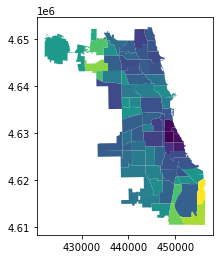

In [41]:
com_areas.plot(column="av_area_num")

In [77]:
com_areas2 = com_areas[["area_numbe", "community", "geometry"]]

In [78]:
com_areas2

,area_numbe,community,geometry
0,35,DOUGLAS,"POLYGON ((1181573.250 1886828.039, 1181571.200..."
1,36,OAKLAND,"POLYGON ((1186289.356 1876750.733, 1186247.037..."
2,37,FULLER PARK,"POLYGON ((1176344.998 1871187.546, 1176346.500..."
3,38,GRAND BOULEVARD,"POLYGON ((1182322.043 1876674.730, 1182323.670..."
4,39,KENWOOD,"POLYGON ((1186289.356 1876750.733, 1186290.775..."
...,...,...,...
72,74,MOUNT GREENWOOD,"POLYGON ((1158152.274 1836518.250, 1158160.983..."
73,75,MORGAN PARK,"POLYGON ((1173045.882 1828593.191, 1172952.890..."
74,76,OHARE,"MULTIPOLYGON (((1119302.584 1938024.319, 11193..."
75,77,EDGEWATER,"POLYGON ((1168756.115 1942653.009, 1168756.116..."


In [145]:
com_areas = read_spatial("data/com_areas_chi", "32616")
com_areas = com_areas[["area_numbe", "community", "geometry"]]
com_no_geom = com_areas[["area_numbe", "community"]]

data/com_areas_chi EPSG:32616


In [214]:
com_areas2.crs

<Projected CRS: EPSG:32616>
Name: WGS 84 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°W and 84°W, northern hemisphere between equator and 84°N, onshore and offshore. Belize. Canada - Manitoba; Nunavut; Ontario. Costa Rica. Cuba. Ecuador - Galapagos. El Salvador. Guatemala. Honduras. Mexico. Nicaragua. United States (USA).
- bounds: (-90.0, 0.0, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [145]:
def compute_zonal_stats(path_to_raster, vector, band_name):
    '''
    Inputs: 
        path_to_raster (string): path to raster data
        vector (geopandas df): 
        band_name (string): name of band
    Outputs:
        nparray (1D np array): mean values of the raster data 
                             ordered by com area order
    '''
    col_name = "mean_" + band_name
    sum_stats = zonal_stats(vector, file, 
                            # nodata = Nan,
                            stats=["mean"])
    print(sum_stats)
    df = pd.DataFrame(sum_stats)
    print(df)
    df = df.rename(columns = {"mean": col_name})
    nparray = np.array(df)
    
    return nparray


file = "../data_2013_2015/LC08_L2SP_022031_20130524_20200913_02_T1/LC08_L2SP_022031_20130524_20200913_02_T1_SR_B1.TIF"
a = compute_zonal_stats(file, com_areas2, "b1")
print(a.shape, a)


[{'mean': 10530.797393862968}, {'mean': 10434.438955139125}, {'mean': 10824.887972841902}, {'mean': 10625.19534697152}, {'mean': 10452.619765494137}, {'mean': 10316.13923013923}, {'mean': 9973.613132006405}, {'mean': 10499.618115318417}, {'mean': None}, {'mean': 11256.966968667422}, {'mean': 10234.967129837143}, {'mean': 9324.507578235743}, {'mean': None}, {'mean': 10595.425144300145}, {'mean': 10325.482743440747}, {'mean': 10479.234815618222}, {'mean': 10003.07959546774}, {'mean': 10208.49629106323}, {'mean': 10619.792479602696}, {'mean': 10533.557448065374}, {'mean': 10655.713774597496}, {'mean': 11124.941124780316}, {'mean': None}, {'mean': 10831.789869029275}, {'mean': 10998.76577605237}, {'mean': 10433.435006810663}, {'mean': None}, {'mean': 10582.6869251578}, {'mean': None}, {'mean': 10602.13388804841}, {'mean': None}, {'mean': 10747.255312689738}, {'mean': 11194.639225469233}, {'mean': 11422.425092538477}, {'mean': 11060.456833275079}, {'mean': 9952.80006362335}, {'mean': 10677.

In [143]:
!ls ../data_2013_2015/LC08_L2SP_022031_20130524_20200913_02_T1/LC08_L2SP_022031_20130524_20200913_02_T1_SR_B1.TIF

LC08_L2SP_022031_20130524_20200913_02_T1_ANG.txt
LC08_L2SP_022031_20130524_20200913_02_T1_MTL.json
LC08_L2SP_022031_20130524_20200913_02_T1_MTL.txt
LC08_L2SP_022031_20130524_20200913_02_T1_MTL.xml
LC08_L2SP_022031_20130524_20200913_02_T1_QA_PIXEL.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_QA_RADSAT.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_B1.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_B2.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_B3.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_B4.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_B5.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_B6.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_B7.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_QA_AEROSOL.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_SR_stac.json
LC08_L2SP_022031_20130524_20200913_02_T1_ST_ATRAN.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_ST_B10.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_ST_CDIST.TIF
LC08_L2SP_022031_20130524_20200913_02_T1_ST_DRAD.TIF
LC08_L2SP_0